In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from e3nn.io import CartesianTensor
from e3nn.o3 import ReducedTensorProducts
from typing import Dict, Union
from utils.data import train_valid_test_split
from utils.e3nn import Network

import cmcrameri.cm as cm

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# utilities
import time
from tqdm import tqdm
# from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, plot_partials,
#                               palette, colors, cmap)
# from utils.utils_model import Network, visualize_layers, train
# from utils.utils_plot import plotly_surface, plot_orbitals, get_middle_feats
from utils.data import (load_data)


import warnings
warnings.filterwarnings("ignore")

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
tqdm.pandas(bar_format=bar_format)
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
device = "cpu"

# load data
df, species = load_data('data/bec_run.db')

In [2]:
# Get species
species = ['H', 'O', 'Ni', 'Nd']
species = [Atom(k).number for k in species]
#n_species = list(np.unique(crd.data['species'].sum(), return_counts=True)[1])
Z_max = max([Atom(k).number for k in species])
print(Z_max)

# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, Z_max+1), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

60


100%|██████████| 60/60 [00:00<00:00, 184635.54it/s]                                                                          


In [3]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=3.5):

    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x_in=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
        z_in=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        y=CartesianTensor("ij=ji").from_cartesian(torch.from_numpy(entry.diel), rtp=ReducedTensorProducts('ij=ji', i='1o')).unsqueeze(0),
        b=CartesianTensor("i=i").from_cartesian(torch.from_numpy(entry.bec)).unsqueeze(0)
    )

    return data

r_max = 3.5 # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 89/89 [00:20<00:00,  4.45it/s]                                                                              


In [238]:
# Train/valid/test split
test_size = 0.1
idx_train, idx_valid, idx_test = train_valid_test_split(df.data, valid_size=test_size, test_size=test_size)

In [239]:
# Format dataloaders
batch_size = 4
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].tolist(), batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].tolist(), batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].tolist(), batch_size=batch_size)

In [240]:
entry = df.iloc[idx_test].iloc[6]
torch.from_numpy(entry.bec.ravel()).shape

torch.Size([216])

In [241]:
class E3NN(Network):
    def __init__(self, in_dim, emb_dim, num_layers, max_radius, num_neighbors):
         
        kwargs = {'reduce_output': False,
                  'irreps_in': str(emb_dim)+"x0e",
                  'irreps_out': str(9) + "x0e",
                  #'irreps_out': str(9) + "x0e",
                  'irreps_node_attr': str(emb_dim)+"x0e",
                  'layers': num_layers,
                  'mul': 32,
                  'lmax': 2,
                  'max_radius': max_radius,
                  'number_of_basis': 10,
                  'radial_layers': 2,
                  'radial_neurons': 64,
                  'num_neighbors': num_neighbors
                 }
        super().__init__(**kwargs)
        
        # definitions
        self.cmap = cm.lipari
        self.in_dim = in_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.max_radius = max_radius
        self.num_neighbors = num_neighbors
        
        self.model_name = 'bec_e' + str(emb_dim) + '_l' + str(num_layers)
        
        # embedding
        self.emb_x = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.ReLU()
        )
        
        self.emb_z = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.Tanh()
        )
    
    def transform(self, data):
        data['x'] = self.emb_x(data['x_in'])
        data['z'] = self.emb_z(data['z_in'])
        return super().forward(data
)[0]
    
    # def get_raman(self, y, data, batch):
    #     y = self.tij.to_cartesian(y, self.rtp)
    #     ones = torch.ones_like(y[:,0,0])
    #     dy = torch.stack([torch.autograd.grad(k, data['pos'], ones, create_graph=True)[0] for k in y.flatten(start_dim=1).T])
    #     dy = dy.permute(1,0,2)

    #     dy_list = unbatch(dy, batch)
    #     pos_list = unbatch(data['pos'], batch)
    #     m_list = unbatch(data['m'], batch)
        
    #     batch_ids, n_modes = torch.unique(batch, sorted=True, return_counts=True)
    #     batch2 = torch.repeat_interleave(batch_ids, 3*n_modes**2, dim=0)
    #     eigen_list = unbatch(data['eigenvec'], batch2)
        
    #     R = []
    #     for i in range(len(pos_list)):
    #         R.append(self.tij.from_cartesian((torch.sum(
    #             torch.einsum('nij,nmj->nmi', dy_list[i], eigen_list[i].view(len(pos_list[i]),-1,3)/torch.sqrt(m_list[i][...,None])),
    #             dim=0)*data['vol'][i]/4./np.pi).view(-1,3,3), self.rtp))
    #     return torch.cat(R)
        
    
    def forward(self, data):
        x = self.transform(data)
        # aggregate
        # if 'batch' in data:
        #     batch = data['batch']
        # else:
        #     batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)
        #y = torch_scatter.scatter_mean(x, batch, dim=0)
        x=x.reshape(-1,3,3).unsqueeze(0)
        x -= torch.mean(x, axis=1)
        return x
    
    
    def count_parameters(self): 
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    

    def loss_bec(self, b_pred, b_true):
        # print(b_pred.shape)
        # print(b_true.shape)
        return nn.MSELoss()(b_pred[:,-4:], b_true[:,-4:])

    
    # def loss_raman(self, y_pred, y_true):
    #     return nn.MSELoss()(y_pred, y_true)
    
    
    def checkpoint(self, dataloader, device):
        self.eval()
        
        loss_cum = 0.
        #with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            d.pos.requires_grad = True
            y_bec = self.forward(d)
            
            loss_bec = self.loss_bec(y_bec, d.b).cpu()
            #loss_raman = self.loss_raman(y_raman_pred, d.raman).cpu()
            loss = loss_bec
            
            loss_cum += loss.detach().item()
                
        return loss_cum/len(dataloader)

    
    def fit(self, opt, dataloader_train, dataloader_valid, history, s0, max_iter=10, device="cpu", scheduler=None):
        chkpt = 1

        for step in range(max_iter):
            self.train()

            loss_bec = 0.
            loss_bec_cum = 0.
            #loss_raman_cum = 0.
            loss_cum = 0.
            start_time = time.time()

            for j, d in enumerate(dataloader_train):
                d.to(device)
                d.pos.requires_grad = True
                y_bec = self.forward(d)
                
                loss_bec = self.loss_bec(y_bec, d.b).cpu()
                #loss_raman = self.loss_raman(y_raman_pred, d.raman).cpu()
                loss = loss_bec #+ loss_raman
                
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"batch loss = {loss.data:.4e}, bec. = {loss_bec.data:.4e}", end="\r", flush=True)

                loss_bec_cum += loss_bec.detach().item()
                #loss_raman_cum += loss_raman.detach().item()
                loss_cum += loss.detach().item()
                
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            if scheduler is not None:
                scheduler.step()
            
            end_time = time.time()
            wall = end_time - start_time

            if (step+1)%chkpt == 0:
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"epoch loss = {loss_cum/len(dataloader_train):.4e}, bec. = {loss_bec_cum/len(dataloader_train):.4e}")

                loss_valid = self.checkpoint(dataloader_valid, device)
                loss_train = self.checkpoint(dataloader_train, device)

                history.append({
                    'step': step + s0,
                    'wall': wall,
                    'batch': {
                        'loss': loss.item(),
                    },
                    'valid': {
                        'loss': loss_valid,
                    },
                     'train': {
                         'loss': loss_train,
                     },
                })

                yield {
                    'history': history,
                    'state': self.state_dict(),
                    'optimizer': opt.state_dict(),
                    'scheduler': scheduler.state_dict() if scheduler else None
                }

In [242]:
#Z_max = 4
args_enn = {'in_dim': Z_max,
            'emb_dim': 4,
            'num_layers': 2,
            'max_radius': r_max,
            'num_neighbors': 10,
           }

enn = E3NN(**args_enn).to(device)
opt = torch.optim.Adam(enn.parameters(), lr=3e-3)
scheduler = None #torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

model_num = 1
model_path = 'models/' + enn.model_name + '_' + str(model_num) + '.torch'

print(model_path)
#print(enn)
print('Number of parameters:', enn.count_parameters())

models/bec_e4_l2_1.torch
Number of parameters: 233128


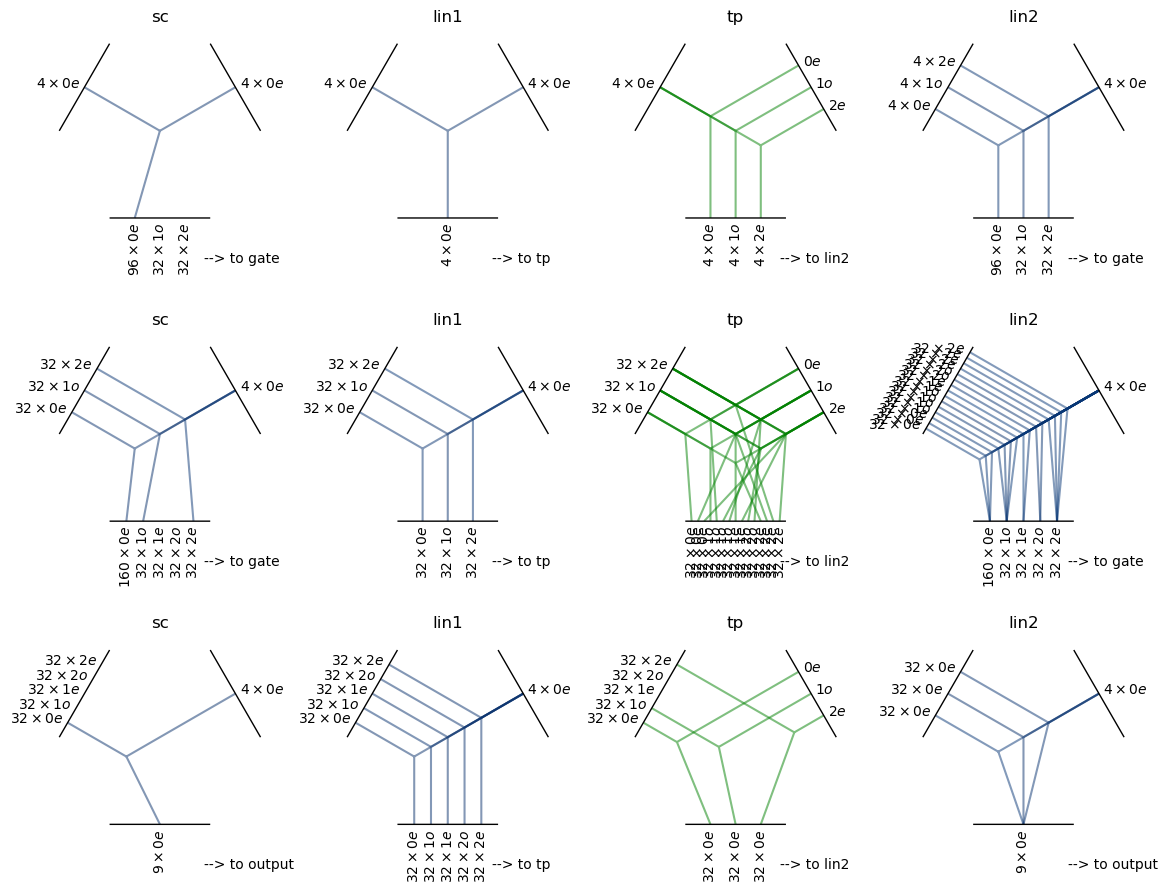

In [243]:
fig = enn.visualize()

In [244]:
resume = False
    
if resume:
    saved = torch.load(model_path, map_location=device)
    enn.load_state_dict(saved['state'])
    opt.load_state_dict(saved['optimizer'])
    try:
        scheduler.load_state_dict(saved['scheduler'])
    except:
        scheduler = None
    history = saved['history']
    s0 = history[-1]['step'] + 1

else:
    history = []
    s0 = 0

In [245]:
# fit E3NN
for results in enn.fit(opt, dataloader_train, dataloader_valid, history, s0, max_iter=50, device=device,
                       scheduler=scheduler):
    with open(model_path, 'wb') as f:
        torch.save(results, f)

Iteration     1    batch    18 /    18   epoch loss = 2.9068e-01, bec. = 2.9068e-01
Iteration     2    batch    18 /    18   epoch loss = 2.2251e-01, bec. = 2.2251e-01
Iteration     3    batch    18 /    18   epoch loss = 1.0362e-01, bec. = 1.0362e-01
Iteration     4    batch    18 /    18   epoch loss = 9.5890e-02, bec. = 9.5890e-02
Iteration     5    batch    18 /    18   epoch loss = 9.3083e-02, bec. = 9.3083e-02
Iteration     6    batch    18 /    18   epoch loss = 9.2835e-02, bec. = 9.2835e-02
Iteration     7    batch    18 /    18   epoch loss = 9.2521e-02, bec. = 9.2521e-02
Iteration     8    batch    18 /    18   epoch loss = 9.2861e-02, bec. = 9.2861e-02
Iteration     9    batch    18 /    18   epoch loss = 9.2617e-02, bec. = 9.2617e-02
Iteration    10    batch    18 /    18   epoch loss = 9.2664e-02, bec. = 9.2664e-02
Iteration    11    batch    18 /    18   epoch loss = 9.3211e-02, bec. = 9.3211e-02
Iteration    12    batch    18 /    18   epoch loss = 9.3043e-02, bec. = 9.3

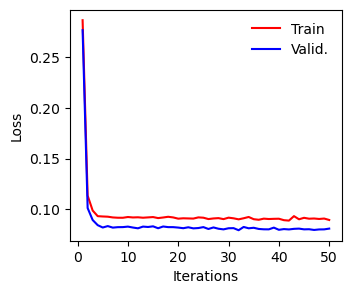

In [246]:
saved = torch.load(model_path, map_location=device)
history = saved['history']

steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(steps, loss_train, label='Train', color='red')
ax.plot(steps, loss_valid, label='Valid.', color='blue')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
#ax.set_yscale('log')
#fig.savefig('images/' + enn.model_name + '_' + str(model_num) + '/loss.svg', bbox_inches='tight')

In [247]:
entry = df.iloc[idx_test].iloc[6]
entry
x = tg.data.Batch.from_data_list([entry.data])
x.pos.requires_grad = True
#
bec_pred = enn(x.to(device))
bec_pred = CartesianTensor("i=i").to_cartesian(bec_pred[0].detach().cpu())[0]

true:
[[ 0.582195   -0.11976709 -0.06266127]
 [-0.0689193   1.20015797  0.28758902]
 [-0.09338435  0.31945076  0.49196663]]
predicted:
tensor([[ 0.7785, -0.0319, -0.0125],
        [-0.0301,  0.8743,  0.0481],
        [ 0.0040,  0.0158,  0.6472]])


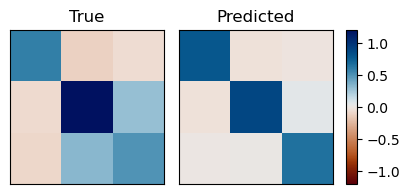

In [248]:
entry = df.iloc[idx_test].iloc[0]
idx_to_plt = 20
x = tg.data.Batch.from_data_list([entry.data])
x.pos.requires_grad = True
bec_pred = enn(x.to(device))
bec_pred = CartesianTensor("i=i").to_cartesian(bec_pred.detach().cpu())[0]


fig, ax = plt.subplots(1,3, figsize=(4.5,2), gridspec_kw={'width_ratios': [1,1,0.07]})
plt.subplots_adjust(wspace=0.1)
vmax = np.abs(entry.bec[idx_to_plt]).max()
norm = plt.Normalize(vmin=-vmax, vmax=vmax)

sm = mpl.cm.ScalarMappable(cmap=cm.vik_r, norm=norm)

ax[0].imshow(entry.bec[idx_to_plt], cmap=sm.cmap, norm=sm.norm)
ax[0].set_title('True')

ax[1].imshow(bec_pred[idx_to_plt], cmap=sm.cmap, norm=sm.norm)
ax[1].set_title('Predicted')

ax[0].set_xticks([]); ax[1].set_xticks([])
ax[0].set_yticks([]); ax[1].set_yticks([])

plt.colorbar(sm, cax=ax[2]);

print('true:')
print(entry.bec[idx_to_plt])

print('predicted:')
print(bec_pred[idx_to_plt])

#fig.savefig('example_dielectric_' + entry.formula.replace(' ','') + '.svg', bbox_inches='tight', transparent=True)

In [249]:
entry.bec[-4:]

array([[[ 0.582195  , -0.11976709, -0.06266127],
        [-0.0689193 ,  1.20015797,  0.28758902],
        [-0.09338435,  0.31945076,  0.49196663]],

       [[ 0.86402269, -0.47917353,  0.30448398],
        [-0.5043581 ,  0.662473  , -0.32581553],
        [ 0.31058127, -0.33502106,  0.84045113]],

       [[ 0.75960865,  0.42753452, -0.31313542],
        [ 0.48096749,  0.71728636, -0.2970053 ],
        [-0.33781628, -0.2923464 ,  0.80994228]],

       [[ 0.67545028,  0.05136847,  0.08783743],
        [ 0.14057247,  0.60555767, -0.04870428],
        [ 0.20801304, -0.00152703,  0.71961748]]])

In [250]:
bec_pred[-4:]

tensor([[[ 7.7847e-01, -3.1930e-02, -1.2458e-02],
         [-3.0086e-02,  8.7434e-01,  4.8063e-02],
         [ 4.0489e-03,  1.5825e-02,  6.4722e-01]],

        [[ 8.3163e-01, -7.4038e-02, -3.0484e-03],
         [-1.2215e-01,  8.3456e-01,  7.3692e-02],
         [ 2.2392e-05,  6.8626e-02,  6.9949e-01]],

        [[ 7.8873e-01,  2.0027e-01, -1.7609e-02],
         [ 2.2524e-01,  7.8375e-01, -2.0602e-02],
         [ 3.9466e-03, -4.3148e-03,  7.0628e-01]],

        [[ 8.1301e-01,  8.4626e-02, -4.3488e-02],
         [ 1.0367e-01,  7.4293e-01, -9.3324e-03],
         [-1.8113e-02,  1.1504e-02,  6.2654e-01]]])

In [251]:
torch.from_numpy(entry.bec[-4:])-bec_pred[-4:]

tensor([[[-0.1963, -0.0878, -0.0502],
         [-0.0388,  0.3258,  0.2395],
         [-0.0974,  0.3036, -0.1553]],

        [[ 0.0324, -0.4051,  0.3075],
         [-0.3822, -0.1721, -0.3995],
         [ 0.3106, -0.4036,  0.1410]],

        [[-0.0291,  0.2273, -0.2955],
         [ 0.2557, -0.0665, -0.2764],
         [-0.3418, -0.2880,  0.1037]],

        [[-0.1376, -0.0333,  0.1313],
         [ 0.0369, -0.1374, -0.0394],
         [ 0.2261, -0.0130,  0.0931]]])